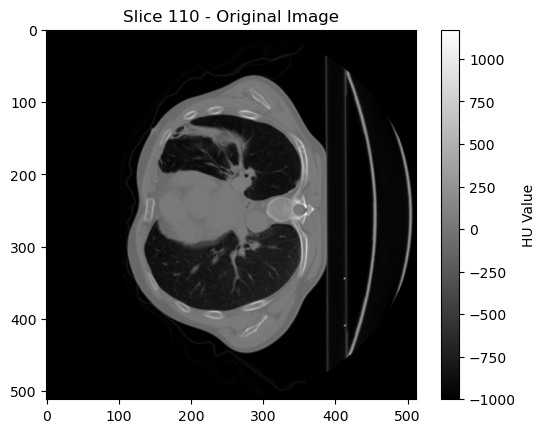

In [8]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import copy
from batchgenerators.transforms.utility_transforms import OneOfTransform
from batchgenerators.transforms.spatial_transforms import SpatialTransform
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform
from batchgenerators.transforms.color_transforms import (
    BrightnessTransform,
    ContrastAugmentationTransform,
    GammaTransform,
)
from batchgenerators.transforms.spatial_transforms import (
    MirrorTransform,
    Rot90Transform,
    TransposeAxesTransform,
)
from batchgenerators.transforms.resample_transforms import SimulateLowResolutionTransform
from batchgenerators.transforms.noise_transforms import MedianFilterTransform, GaussianBlurTransform
from batchgenerators.transforms.noise_transforms import SharpeningTransform
from batchgenerators.transforms.abstract_transforms import Compose

from pathlib import Path


# Load the .nii.gz file for the patient
input_file_path = Path("..") / "data" / "segthor_train" / "train" / "Patient_01" / "Patient_01.nii.gz"

# Load the image using nibabel
real_1 = nib.load(input_file_path)
image_data = real_1.get_fdata()

# Add channel and batch dimensions
image_data = image_data[np.newaxis, np.newaxis, ...]  # New shape: (1, 1, 512, 512, 229)

# Visualize the original image slice
slice_number = 110
plt.imshow(image_data[0, 0, :, :, slice_number], cmap="gray")
plt.title(f"Slice {slice_number} - Original Image")
plt.colorbar(label='HU Value')
plt.show()

patch_size = (128, 128, 128)

In [9]:
def apply_and_visualize_transform(transform, image_data, slice_number, title):
    # Create a deep copy of the image data to prevent in-place modifications
    image_data_copy = copy.deepcopy(image_data)
    # If no transform is provided, use the original image data
    if transform is None:
        augmented_data = {'data': image_data_copy}
    else:
        # Apply the transform
        augmented_data = transform(data=image_data_copy)
    # Extract the augmented image
    augmented_image = augmented_data['data'][0, 0]
    # Visualize the augmented image slice with proper scaling
    plt.imshow(
        augmented_image[:, :, slice_number],
        cmap='gray')
    plt.title(title)
    plt.colorbar(label='HU Value')
    plt.show()




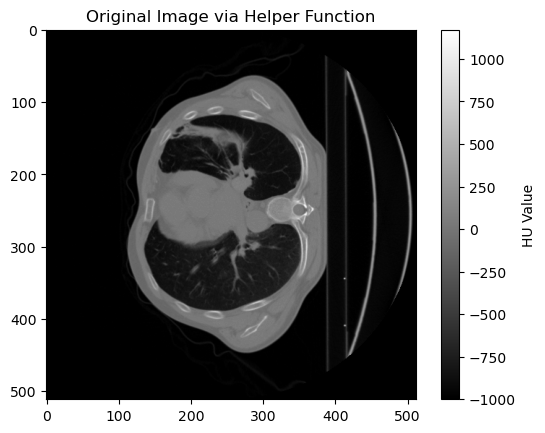

In [10]:
    
# Apply and visualize the original image using the helper function
apply_and_visualize_transform(None, image_data, slice_number, "Original Image via Helper Function")



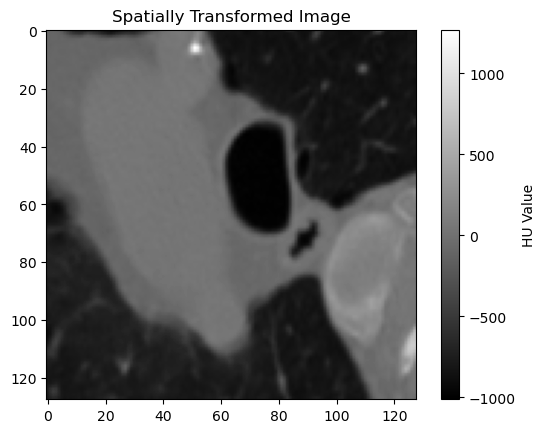

In [11]:
# 1st Augementation: Define the combined spatial transformation (rotation and scaling)
# SpatialTransform parameters
spatial_transform = SpatialTransform(
    patch_size=patch_size,
    patch_center_dist_from_border=None,
    do_elastic_deform=False,
    do_rotation=True,
    angle_x=(-30 / 360 * 2. * np.pi, 30 / 360 * 2. * np.pi),
    angle_y=(-30 / 360 * 2. * np.pi, 30 / 360 * 2. * np.pi),
    angle_z=(-30 / 360 * 2. * np.pi, 30 / 360 * 2. * np.pi),
    p_rot_per_axis=1.0,  # Ensure rotation is applied
    do_scale=True,
    scale=(0.7, 1.43),
    border_mode_data="constant",
    border_cval_data=0,
    order_data=3,
    border_mode_seg="constant",
    border_cval_seg=-1,
    order_seg=1,
    random_crop=False,
    p_el_per_sample=0.0,  # No elastic deformation
    p_scale_per_sample=1.0,  # Ensure scaling is applied
    p_rot_per_sample=1.0,  # Ensure rotation is applied
    independent_scale_for_each_axis=True,
)

# Apply and visualize
apply_and_visualize_transform(spatial_transform, image_data, slice_number, "Spatially Transformed Image")


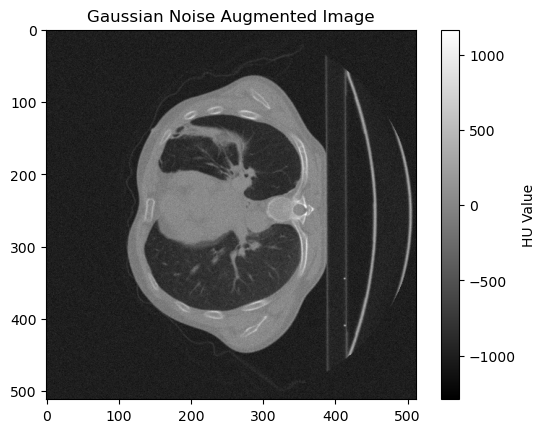

In [12]:
#2nd Augementation: Gaussian Noise
# GaussianNoiseTransform parameters
gaussian_noise_transform = GaussianNoiseTransform(
    noise_variance=(0, 100), #0.1 orignially
    p_per_sample=1.0  # Ensure noise is applied
)

# Apply and visualize
apply_and_visualize_transform(gaussian_noise_transform, image_data, slice_number, "Gaussian Noise Augmented Image")

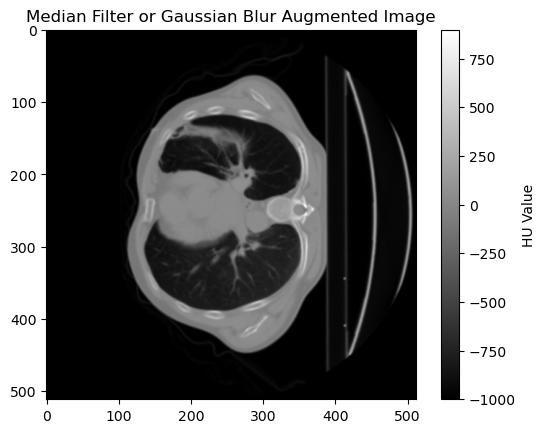

In [13]:
# 3rd Augmentation: Median Filter or Gaussian Blur
one_of_transform = OneOfTransform([
    MedianFilterTransform(
        filter_size=(2, 8),
        same_for_each_channel=False,
        p_per_sample=1.0,  
        p_per_channel=1.0
    ),
    GaussianBlurTransform(
        blur_sigma=(0.3, 1.5),
        different_sigma_per_channel=True,
        p_per_sample=1.0,  
        p_per_channel=1.0
    )
])

# Apply and visualize the transform
apply_and_visualize_transform(one_of_transform, image_data, slice_number, "Median Filter or Gaussian Blur Augmented Image")


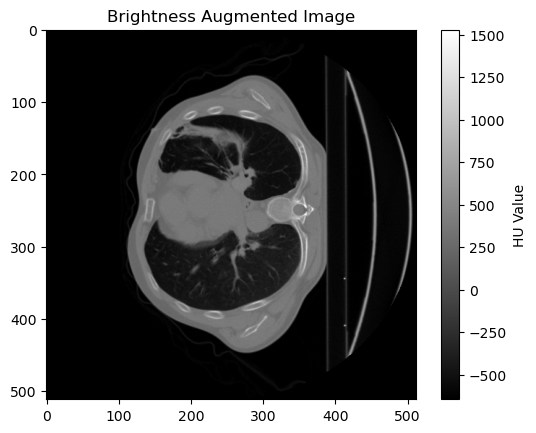

In [32]:
# 4th Augmentation: Brightness Transform (#not working)
# BrightnessTransform parameters
brightness_transform = BrightnessTransform(
    mu=0,
    sigma=1000, # 0.5 (normal amount for range 0-1) * relevant range (from -1000, 1000)
    per_channel=True,
    p_per_sample=1.0,
    p_per_channel=1.0
)

# Apply and visualize
apply_and_visualize_transform(brightness_transform, image_data, slice_number, "Brightness Augmented Image")

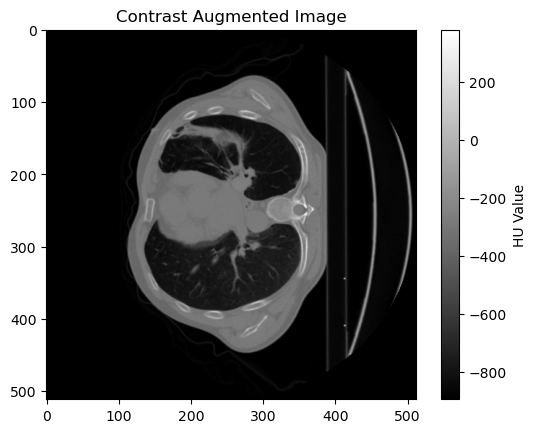

In [15]:
#5th Augmentation: Contrast
# ContrastAugmentationTransform parameters (preserve_range=True)
contrast_transform = ContrastAugmentationTransform(
    contrast_range=(0.5, 2),
    preserve_range=True,
    per_channel=True,
    data_key='data',
    p_per_sample=1.0,
    p_per_channel=1.0
)

# Apply and visualize
apply_and_visualize_transform(contrast_transform, image_data, slice_number, "Contrast Augmented Image")

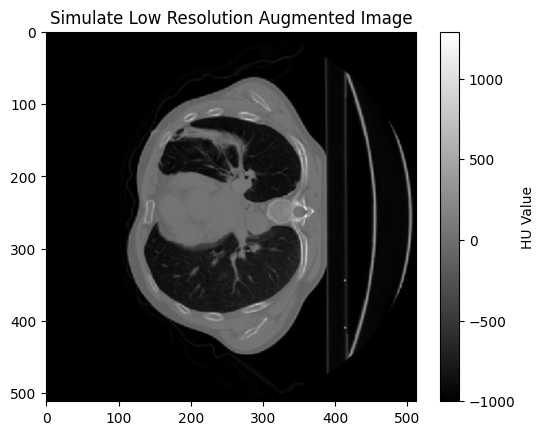

In [29]:
# 6th Augmentation: Low Resolution Simulation
# SimulateLowResolutionTransform parameters
simulate_lowres_transform = SimulateLowResolutionTransform(
    zoom_range=(0.25, 1),
    per_channel=True,
    p_per_channel=1.0,
    order_downsample=0,
    order_upsample=3,
    p_per_sample=1.0,
    ignore_axes=None
)

# Apply and visualize
apply_and_visualize_transform(simulate_lowres_transform, image_data, slice_number, "Simulate Low Resolution Augmented Image")


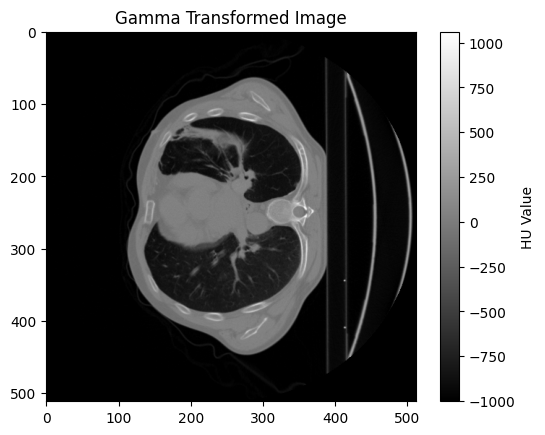

In [44]:
# 7th Augmentation: Gamma Transform
# GammaTransform parameters
gamma_transform = GammaTransform(
    gamma_range=(0.7, 1.5),
    invert_image=True,
    per_channel=True,
    retain_stats=True,
    p_per_sample=1.0
)

# Apply and visualize
apply_and_visualize_transform(gamma_transform, image_data, slice_number, "Gamma Transformed Image")


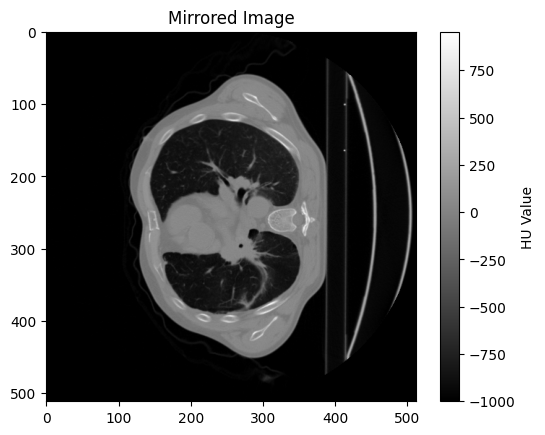

In [35]:
# 8th Augmentation: Mirroring
# MirrorTransform parameters
mirror_transform = MirrorTransform(
    axes=(0, 1, 2)
)

# Apply and visualize
apply_and_visualize_transform(mirror_transform, image_data, slice_number, "Mirrored Image")



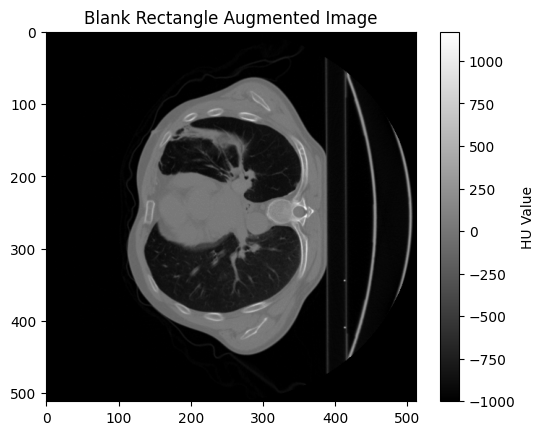

In [337]:
#9th Augmentation: Rectangle 
# Calculate rectangle size ranges based on patch size
rectangle_size = [[max(1, p // 10), p // 3] for p in patch_size]

# BlankRectangleTransform parameters
blank_rectangle_transform = BlankRectangleTransform(
    rectangle_size=rectangle_size,
    rectangle_value=np.mean,
    num_rectangles=(1, 5),
    force_square=False,
    p_per_sample=1.0,
    p_per_channel=1.0
)

# Apply and visualize
apply_and_visualize_transform(blank_rectangle_transform, image_data, slice_number, "Blank Rectangle Augmented Image")


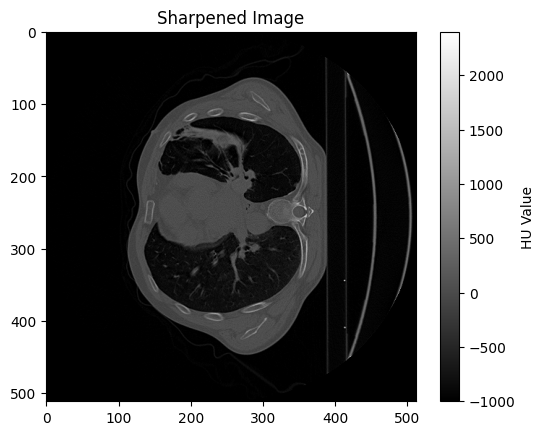

In [338]:
# 10th Augmentation: Sharpening
# SharpeningTransform parameters
sharpening_transform = SharpeningTransform(
    strength=(0.1, 1),
    same_for_each_channel=False,
    p_per_sample=1.0,
    p_per_channel=1.0
)

# Apply and visualize
apply_and_visualize_transform(sharpening_transform, image_data, slice_number, "Sharpened Image")
